In [284]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
!pip install pyramid
from pmdarima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [285]:
covid=pd.read_csv("/content/TAMILNADU (2).csv")
covid.head()

,date,state,confirmed,new conf,% of infected,recovered,new rec,% of rec,dead,new dead,% of dead,other,tested,% of tested,first dose,second dose,% of first dose,% of second dose
0,4/1/2021,Tamil Nadu,889490,2817,1.128794,859709,1634,96.651902,12738,19,1.432057,0,19681244,24.976198,2835444,279179,3.598279,0.354288
1,4/2/2021,Tamil Nadu,892780,3290,1.132970,861424,1715,96.487825,12750,12,1.428123,0,19767310,25.085419,2829190,272288,3.590343,0.345543
2,4/3/2021,Tamil Nadu,896226,3446,1.137343,863258,1834,96.321464,12764,14,1.424194,0,19849388,25.189579,2871776,279902,3.644386,0.355206
3,4/4/2021,Tamil Nadu,899807,3581,1.141887,865071,1813,96.139617,12778,14,1.420082,0,19932179,25.294643,2901208,285389,3.681736,0.362169
4,4/5/2021,Tamil Nadu,903479,3672,1.146547,866913,1842,95.952756,12789,11,1.415528,0,20012235,25.396237,2907580,298198,3.689822,0.378424


In [286]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (183, 18)
Checking for null values:
 date                0
state               0
confirmed           0
new conf            0
% of infected       0
recovered           0
new rec             0
% of rec            0
dead                0
new dead            0
% of dead           0
other               0
tested              0
% of tested         0
first dose          0
second dose         0
% of first dose     0
% of second dose    0
dtype: int64
Checking Data-type of each column:
 date                 object
state                object
confirmed             int64
new conf              int64
% of infected       float64
recovered             int64
new rec               int64
% of rec            float64
dead                  int64
new dead              int64
% of dead           float64
other                 int64
tested                int64
% of tested         float64
first dose            int64
second dose           int64
% of first dose     float64
% of second do

In [287]:
covid["date"]=pd.to_datetime(covid["date"])

In [288]:
grouped=covid.groupby(["state","date"]).agg({"confirmed":'sum',"recovered":'sum',"dead":'sum'})
grouped

confirmed  recovered   dead
state      date                                   
Tamil Nadu 2021-04-01     889490     859709  12738
           2021-04-02     892780     861424  12750
           2021-04-03     896226     863258  12764
           2021-04-04     899807     865071  12778
           2021-04-05     903479     866913  12789
...                          ...        ...    ...
           2021-09-26    2657266    2604491  35490
           2021-09-27    2658923    2606153  35509
           2021-09-28    2660553    2607796  35526
           2021-09-29    2662177    2609435  35550
           2021-09-30    2663789    2611061  35578

[183 rows x 3 columns]

In [289]:
grouped["Active Cases"]=grouped["confirmed"]-grouped["recovered"]-grouped["dead"]
grouped["log_confirmed"]=np.log(grouped["confirmed"])
grouped["log_active"]=np.log(grouped["Active Cases"])
grouped

confirmed  recovered  ...  log_confirmed  log_active
state      date                              ...                           
Tamil Nadu 2021-04-01     889490     859709  ...      13.698404    9.743495
           2021-04-02     892780     861424  ...      13.702095    9.831239
           2021-04-03     896226     863258  ...      13.705948    9.913636
           2021-04-04     899807     865071  ...      13.709936    9.996887
           2021-04-05     903479     866913  ...      13.714008   10.076474
...                          ...        ...  ...            ...         ...
           2021-09-26    2657266    2604491  ...      14.792808    9.757594
           2021-09-27    2658923    2606153  ...      14.793432    9.756205
           2021-09-28    2660553    2607796  ...      14.794045    9.754465
           2021-09-29    2662177    2609435  ...      14.794655    9.752199
           2021-09-30    2663789    2611061  ...      14.795260    9.749753

[183 rows x 6 columns]

In [290]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["date"]).agg({"confirmed":'sum',"recovered":'sum',"dead":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()
datewise

,confirmed,recovered,dead,Days Since
date,,,,
2021-04-01,889490,859709,12738,0 days
2021-04-02,892780,861424,12750,1 days
2021-04-03,896226,863258,12764,2 days
2021-04-04,899807,865071,12778,3 days
2021-04-05,903479,866913,12789,4 days
...,...,...,...,...
2021-09-26,2657266,2604491,35490,178 days
2021-09-27,2658923,2606153,35509,179 days
2021-09-28,2660553,2607796,35526,180 days


In [291]:
fig=px.bar(x=datewise.index,y=datewise["dead"])
fig.update_layout(title="Distribution of Number of dead Cases",
                  xaxis_title="Date",yaxis_title="Number of deaths",)
fig.show()

In [292]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["dead"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in Tamil Nadu",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

GROWTH RATE OF TAMIL NADU


In [293]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [294]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["dead"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  9696.0
Average increase in number of Recovered Cases every day:  9570.0
Average increase in number of Deaths Cases every day:  125.0


GROWTH FACTOR


In [295]:
#linear regression


In [296]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [297]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [298]:
lin_reg=LinearRegression(normalize=True)

In [299]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["dead"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [300]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [301]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["dead"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["dead"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  6367.037313374716


In [302]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="newly dead Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [303]:
#polynomial regression 
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
poly = PolynomialFeatures(degree = 8) 

In [304]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["dead"]

In [305]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [306]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["dead"],prediction_poly))
model_scores=[]
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  4033.929328927979


In [307]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Death Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


<Figure size 792x432 with 0 Axes>

SVM PREDICTION

In [308]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [309]:
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [310]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["dead"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [311]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [312]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["dead"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["dead"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  7329.581213975804


In [313]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"],
                    mode='lines+markers',name="Train Data for newly dead Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Death Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [314]:
#new polynomial
new_prediction_poly=[]
for i in range(1,365):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [315]:
#new svm prediction
new_date=[]
new_prediction_svm=[]
for i in range(1,365):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [316]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_poly,new_prediction_svm),
                               columns=["date","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction
0,2021-10-01,44495.114581,45478.513196
1,2021-10-02,46155.767294,46043.686337
2,2021-10-03,48032.109538,46624.427899
3,2021-10-04,50144.602820,47221.079088
4,2021-10-05,52515.101177,47833.986692
...,...,...,...
359,2022-09-25,18495429363.409454,11505646.784762
360,2022-09-26,18822763540.271004,11633287.834124
361,2022-09-27,19155135402.187019,11762109.642338
362,2022-09-28,19492610988.858364,11892120.931541


FORECASTING

HOLT'S LINEAR MODEL

In [317]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [318]:
holt=Holt(np.asarray(model_train["dead"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)     

In [319]:
y_pred["Holt"]=holt.forecast(10)
model_scores.append(np.sqrt(mean_squared_error(y_pred["dead"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["dead"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  14.139650772105924


In [320]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Train Data for dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["dead"],
                    mode='lines+markers',name="Validation Data for dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of newly dead Cases",))
fig.update_layout(title="newly dead Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [321]:
#holt new prediction
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,365):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2021-10-01,44495.114581,45478.513196,35620.178009
1,2021-10-02,46155.767294,46043.686337,35643.738237
2,2021-10-03,48032.109538,46624.427899,35667.298466
3,2021-10-04,50144.602820,47221.079088,35690.858694
4,2021-10-05,52515.101177,47833.986692,35714.418923
...,...,...,...,...
359,2022-09-25,18495429363.409454,11505646.784762,44078.300028
360,2022-09-26,18822763540.271004,11633287.834124,44101.860257
361,2022-09-27,19155135402.187019,11762109.642338,44125.420485
362,2022-09-28,19492610988.858364,11892120.931541,44148.980713


HOLT'S WINTER MODEL

In [322]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [323]:
es=ExponentialSmoothing(np.asarray(model_train['dead']),seasonal_periods=14,trend='add', seasonal='mul').fit()

In [324]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["dead"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["dead"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  27.337525394305157


In [325]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Train Data for dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["dead"],
                    mode='lines+markers',name="Validation Data for dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of dead Cases",))
fig.update_layout(title="newly dead Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [326]:
#holt winter new prediction
holt_winter_new_prediction=[]
for i in range(1,365):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2021-10-01,44495.114581,45478.513196,35620.178009,35634.704262
1,2021-10-02,46155.767294,46043.686337,35643.738237,35665.496743
2,2021-10-03,48032.109538,46624.427899,35667.298466,35691.322765
3,2021-10-04,50144.602820,47221.079088,35690.858694,35705.972391
4,2021-10-05,52515.101177,47833.986692,35714.418923,35727.657946


In [327]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

AR MODEL (AUTO ARIMA)

In [328]:
model_ar= auto_arima(model_train["dead"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1545.291, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1541.115, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1542.252, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1538.334, Time=0.18 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1523.487, Time=0.20 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 0.546 seconds


ARIMA(maxiter=50, method='lbfgs', order=(4, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [329]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [330]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["dead"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["dead"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  22.202223217648907


In [331]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Train Data for dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["dead"],
                    mode='lines+markers',name="Validation Data for dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of dead Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [332]:
#ar model new prediction
AR_model_new_prediction=[]
for i in range(1,365):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2021-10-01,44495.114581,45478.513196,35620.178009,35634.704262,35638.364946
1,2021-10-02,46155.767294,46043.686337,35643.738237,35665.496743,35664.528413
2,2021-10-03,48032.109538,46624.427899,35667.298466,35691.322765,35690.866893
3,2021-10-04,50144.602820,47221.079088,35690.858694,35705.972391,35717.197143
4,2021-10-05,52515.101177,47833.986692,35714.418923,35727.657946,35743.601788


MA MODEL (AUTO ARIMA)

In [333]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [334]:
model_ma= auto_arima(model_train["dead"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1545.291, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1541.021, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1542.334, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.193 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [335]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [336]:
model_scores.append(np.sqrt(mean_squared_error(valid["dead"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["dead"],prediction_ma)))

Root Mean Square Error for MA Model:  15.058630267409676


In [337]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Train Data for dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["dead"],
                    mode='lines+markers',name="Validation Data for dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for dead Cases",))
fig.update_layout(title="newly dead Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [338]:
#ma model new prediction
MA_model_new_prediction=[]
for i in range(1,365):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head(60)

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2021-10-01,44495.114581,45478.513196,35620.178009,35634.704262,35638.364946,35623.490061
1,2021-10-02,46155.767294,46043.686337,35643.738237,35665.496743,35664.528413,35647.841027
2,2021-10-03,48032.109538,46624.427899,35667.298466,35691.322765,35690.866893,35672.258215
3,2021-10-04,50144.602820,47221.079088,35690.858694,35705.972391,35717.197143,35696.741623
4,2021-10-05,52515.101177,47833.986692,35714.418923,35727.657946,35743.601788,35721.291252
5,2021-10-06,55166.917663,48463.503135,35737.979151,35754.433954,35770.151674,35745.907101
6,2021-10-07,58124.892956,49109.986540,35761.539380,35777.927040,35796.771999,35770.589172
7,2021-10-08,61415.466125,49773.800794,35785.099608,35811.133191,35823.443820,35795.337463
8,2021-10-09,65066.747597,50455.315601,35808.659837,35848.035118,35850.215561,35820.151975
9,2021-10-10,69108.594365,51154.906553,35832.220065,35875.656171,35877.079270,35845.032708


ARIMA MODEL (AUTO ARIMA)

In [339]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [340]:
model_arima= auto_arima(model_train["dead"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1545.291, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1541.021, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1542.334, Time=0.12 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1535.494, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1541.115, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1542.853, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1510.147, Time=0.22 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1500.022, Time=0.35 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1542.252, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1543.580, Time=0.17 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1525.109, Time=0.53 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1500.738, Time=0.51 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1538.334, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1516.635, Time=0.28 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1500.805, Time=0.41 sec

Best mode

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [341]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [342]:
model_scores.append(np.sqrt(mean_squared_error(valid["dead"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["dead"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  5.153643859454865


In [343]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["dead"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Dead Cases",))
fig.update_layout(title="newly dead Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [344]:
ARIMA_model_new_prediction=[]
for i in range(1,365):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2021-10-01,44495.114581,45478.513196,35620.178009,35634.704262,35638.364946,35623.490061,35587.082555
1,2021-10-02,46155.767294,46043.686337,35643.738237,35665.496743,35664.528413,35647.841027,35603.919846
2,2021-10-03,48032.109538,46624.427899,35667.298466,35691.322765,35690.866893,35672.258215,35620.253200
3,2021-10-04,50144.602820,47221.079088,35690.858694,35705.972391,35717.197143,35696.741623,35636.110610
4,2021-10-05,52515.101177,47833.986692,35714.418923,35727.657946,35743.601788,35721.291252,35651.518711


SARIMA MODEL (AUTO ARIMA)

In [345]:
model_sarima= auto_arima(model_train["dead"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["dead"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1527.765, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1543.292, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1517.731, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1524.776, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=1539.117, Time=0.03 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=1515.078, Time=0.19 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=1515.554, Time=0.43 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=1513.717, Time=0.21 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=1524.524, Time=0.13 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=1515.445, Time=0.39 sec
 ARIMA(1,2,0)(0,0,2)[7]             : AIC=1521.635, Time=0.24 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=1517.303, Time=1.08 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=1514.617, Time=0.33 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1515.081, Time=0.27 sec
 ARIMA(0,2,1)(1,0,1)[7]          

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [346]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [347]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["dead"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["dead"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  23.704357208286048


In [348]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Train Data for dead Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["dead"],
                    mode='lines+markers',name="Validation Data for dead Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for dead Cases",))
fig.update_layout(title="newly dead Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [349]:
SARIMA_model_new_prediction=[]
for i in range(1,365):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2021-10-01,44495.114581,45478.513196,35620.178009,35634.704262,35638.364946,35623.490061,35587.082555,35638.080888
1,2021-10-02,46155.767294,46043.686337,35643.738237,35665.496743,35664.528413,35647.841027,35603.919846,35663.579702
2,2021-10-03,48032.109538,46624.427899,35667.298466,35691.322765,35690.866893,35672.258215,35620.253200,35689.615096
3,2021-10-04,50144.602820,47221.079088,35690.858694,35705.972391,35717.197143,35696.741623,35636.110610,35714.792476
4,2021-10-05,52515.101177,47833.986692,35714.418923,35727.657946,35743.601788,35721.291252,35651.518711,35741.161430
...,...,...,...,...,...,...,...,...,...
359,2022-09-25,18495429363.409454,11505646.784762,44078.300028,44569.569764,50084.910092,48620.900397,42369.402948,45266.578737
360,2022-09-26,18822763540.271004,11633287.834124,44101.860257,44581.474244,50139.236745,48669.024622,42400.998006,45293.474805
361,2022-09-27,19155135402.187019,11762109.642338,44125.420485,44600.849145,50193.641647,48717.215069,42432.667455,45320.370872
362,2022-09-28,19492610988.858364,11892120.931541,44148.980713,44628.621049,50248.124799,48765.471736,42464.411295,45347.266940


FB PROPHET

In [350]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_dead=pd.DataFrame(zip(list(datewise.index),list(datewise["dead"])),columns=['ds','y'])

In [351]:
prophet_c.fit(prophet_dead)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [352]:
forecast_c=prophet_c.make_future_dataframe(periods=364)
forecast_dead=forecast_c.copy()

In [353]:
dead_forecast=prophet_c.predict(forecast_c)
print(dead_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

            ds         yhat     yhat_lower    yhat_upper
0   2021-04-01 12727.325713   12694.624050  12758.866685
1   2021-04-02 12749.098091   12714.383735  12784.689503
2   2021-04-03 12770.821541   12737.872131  12803.550078
3   2021-04-04 12782.083309   12748.203636  12815.684073
4   2021-04-05 12785.895998   12752.224098  12819.878820
..         ...          ...            ...           ...
542 2022-09-25 43510.939809 -104301.411880 193333.473248
543 2022-09-26 43521.107436 -104860.482545 193840.390303
544 2022-09-27 43542.617561 -105427.074995 194597.200499
545 2022-09-28 43568.986293 -105808.175613 195401.211269
546 2022-09-29 43591.325721 -106385.293292 196219.101179

[547 rows x 4 columns]


In [354]:
model_scores.append(np.sqrt(mean_squared_error(datewise["dead"],dead_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["dead"],dead_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  16.88991420902933


Figure(720x432)


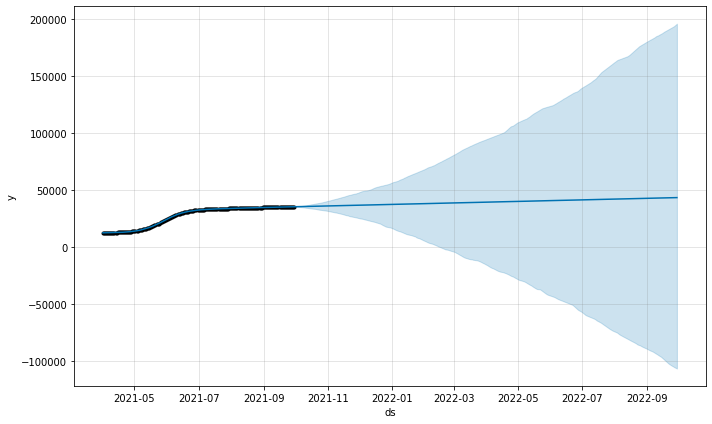

In [355]:
print(prophet_c.plot(dead_forecast))

Figure(648x432)


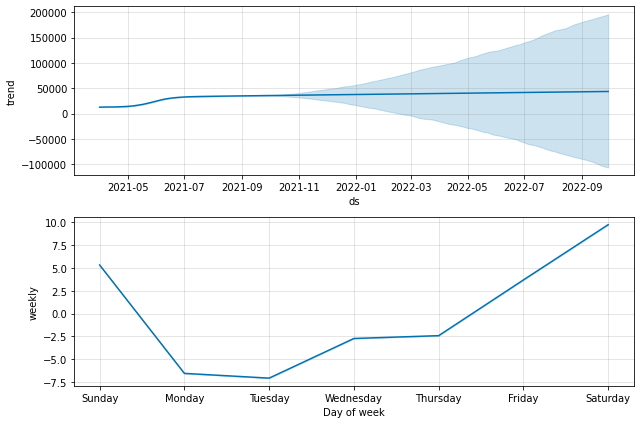

In [356]:
print(prophet_c.plot_components(dead_forecast))

In [357]:
model_names=["Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
6,ARIMA Model,5.153644
2,Holt's Linear,14.139651
5,Moving Average Model (MA),15.058630
8,Facebook's Prophet Model,16.889914
4,Auto Regressive Model (AR),22.202223
7,SARIMA Model,23.704357
3,Holt's Winter Model,27.337525
0,Polynomial Regression,4033.929329
1,Support Vector Machine Regressor,7329.581214


In [358]:
model_predictions["Prophet's Prediction"]=list(dead_forecast["yhat"].tail(364))
model_predictions["Prophet's Upper Bound"]=list(dead_forecast["yhat_upper"].tail(364))
model_predictions["Prophet's Lower Bound"]=list(dead_forecast["yhat_lower"].tail(364))
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound,Prophet's Lower Bound
0,2021-10-01,44495.114581,45478.513196,35620.178009,35634.704262,35638.364946,35623.490061,35587.082555,35638.080888,35600.620359,35638.363181,35561.164857
1,2021-10-02,46155.767294,46043.686337,35643.738237,35665.496743,35664.528413,35647.841027,35603.919846,35663.579702,35628.698747,35702.034842,35556.301117
2,2021-10-03,48032.109538,46624.427899,35667.298466,35691.322765,35690.866893,35672.258215,35620.253200,35689.615096,35646.315452,35790.802041,35502.455503
3,2021-10-04,50144.602820,47221.079088,35690.858694,35705.972391,35717.197143,35696.741623,35636.110610,35714.792476,35656.483079,35871.707158,35416.820588
4,2021-10-05,52515.101177,47833.986692,35714.418923,35727.657946,35743.601788,35721.291252,35651.518711,35741.161430,35677.993204,35984.259192,35359.396179
...,...,...,...,...,...,...,...,...,...,...,...,...
359,2022-09-25,18495429363.409454,11505646.784762,44078.300028,44569.569764,50084.910092,48620.900397,42369.402948,45266.578737,43510.939809,193333.473248,-104301.411880
360,2022-09-26,18822763540.271004,11633287.834124,44101.860257,44581.474244,50139.236745,48669.024622,42400.998006,45293.474805,43521.107436,193840.390303,-104860.482545
361,2022-09-27,19155135402.187019,11762109.642338,44125.420485,44600.849145,50193.641647,48717.215069,42432.667455,45320.370872,43542.617561,194597.200499,-105427.074995
362,2022-09-28,19492610988.858364,11892120.931541,44148.980713,44628.621049,50248.124799,48765.471736,42464.411295,45347.266940,43568.986293,195401.211269,-105808.175613


In [359]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [360]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [361]:
model_arima_deaths=auto_arima(model_train["dead"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["dead"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1545.291, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1541.021, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1542.334, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1535.494, Time=0.16 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=1532.634, Time=0.26 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=1534.429, Time=0.40 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1541.115, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1542.853, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1510.147, Time=0.23 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1500.022, Time=0.37 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=1501.498, Time=0.45 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1542.252, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1543.580, Time=0.17 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1525.109, Time=0.51 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1500.738, Time=0.48 sec
 ARIMA(3,2

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [362]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [363]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["dead"],predictions_deaths)))

Root Mean Square Error:  5.153643859454865


In [364]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["dead"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["dead"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [365]:
ARIMA_model_death_forecast=[]
for i in range(1,365):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [366]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2021-10-01,35587.082555
1,2021-10-02,35603.919846
2,2021-10-03,35620.253200
3,2021-10-04,35636.110610
4,2021-10-05,35651.518711


In [367]:
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound,Prophet's Lower Bound
0,2021-10-01,44495.114581,45478.513196,35620.178009,35634.704262,35638.364946,35623.490061,35587.082555,35638.080888,35600.620359,35638.363181,35561.164857
1,2021-10-02,46155.767294,46043.686337,35643.738237,35665.496743,35664.528413,35647.841027,35603.919846,35663.579702,35628.698747,35702.034842,35556.301117
2,2021-10-03,48032.109538,46624.427899,35667.298466,35691.322765,35690.866893,35672.258215,35620.253200,35689.615096,35646.315452,35790.802041,35502.455503
3,2021-10-04,50144.602820,47221.079088,35690.858694,35705.972391,35717.197143,35696.741623,35636.110610,35714.792476,35656.483079,35871.707158,35416.820588
4,2021-10-05,52515.101177,47833.986692,35714.418923,35727.657946,35743.601788,35721.291252,35651.518711,35741.161430,35677.993204,35984.259192,35359.396179
...,...,...,...,...,...,...,...,...,...,...,...,...
359,2022-09-25,18495429363.409454,11505646.784762,44078.300028,44569.569764,50084.910092,48620.900397,42369.402948,45266.578737,43510.939809,193333.473248,-104301.411880
360,2022-09-26,18822763540.271004,11633287.834124,44101.860257,44581.474244,50139.236745,48669.024622,42400.998006,45293.474805,43521.107436,193840.390303,-104860.482545
361,2022-09-27,19155135402.187019,11762109.642338,44125.420485,44600.849145,50193.641647,48717.215069,42432.667455,45320.370872,43542.617561,194597.200499,-105427.074995
362,2022-09-28,19492610988.858364,11892120.931541,44148.980713,44628.621049,50248.124799,48765.471736,42464.411295,45347.266940,43568.986293,195401.211269,-105808.175613


In [368]:
model_predictions=model_predictions.groupby(["date"]).agg({"Holt's Linear Model Prediction":'sum',"MA Model Prediction":'sum',"ARIMA Model Prediction":'sum',"SARIMA Model Prediction":'sum'})
model_predictions=model_predictions[0:92]
model_predictions.tail()

,Holt's Linear Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
date,,,,
2021-12-27,37669.917885,37989.756077,36534.258414,37951.280070
2021-12-28,37693.478114,38019.868252,36545.778515,37978.166334
2021-12-29,37717.038342,38050.046646,36557.365286,38005.054655
2021-12-30,37740.598571,38080.291262,36569.019101,38031.935247
2021-12-31,37764.158799,38110.602099,36580.740316,38058.795413


In [387]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["Holt's Linear Model Prediction"],
                    mode='lines+markers',
                    name="Holt's Linear Model Prediction"))

fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["ARIMA Model Prediction"],
                    mode='lines+markers',
                    name='ARIMA Model Prediction'))

fig.update_layout(title="Prediction of Death cases",
                 xaxis_title="Date",yaxis_title="Number of cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [385]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"],
                    mode='lines+markers',name="Train Data for Death Cases"))

fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [386]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["dead"],
                    mode='lines+markers',name="Train Data for Death Cases"))

fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["Holt's Linear Model Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()